Nicolas Brandstetter
Felipe Keim

Predicción de inicio y final de un evento de huso del sueño

In [1]:
#Imports
import numpy as np
import torch
from torch import nn
import torchvision
import matplotlib.pyplot as plt
import os
import sys
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


In [2]:
from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision

# loading data

In [3]:
test_marks = np.load('data_sigma_spindles/test_marks.npy')
test_signals = np.load('data_sigma_spindles/test_signals.npy')
train_marks = np.load('data_sigma_spindles/train_marks.npy')
train_signals = np.load('data_sigma_spindles/train_signals.npy')
val_marks = np.load('data_sigma_spindles/val_marks.npy')
val_signals = np.load('data_sigma_spindles/val_signals.npy')

## Normalization

In [4]:
scaler = StandardScaler()
scaler = scaler.fit(np.concatenate((test_signals,train_signals,val_signals)))

val_signals_normalized = scaler.transform(val_signals)
test_signals_normalized = scaler.transform(test_signals)
train_signals_normalized = scaler.transform(train_signals)

In [5]:
val_marks = torch.tensor(val_marks)
test_marks = torch.tensor(test_marks)
train_marks = torch.tensor(train_marks)

val_signals = torch.tensor(val_signals_normalized)
test_signals = torch.tensor(test_signals_normalized)
train_signals = torch.tensor(train_signals_normalized)

In [6]:
train_ds = torch.utils.data.TensorDataset(train_signals, train_marks)
val_ds = torch.utils.data.TensorDataset(val_signals, val_marks)
test_ds = torch.utils.data.TensorDataset(test_signals, test_marks)

## Creating Dataset

tensor([357, 472], dtype=torch.int32)


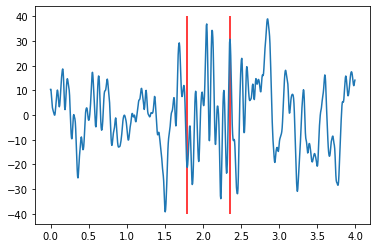

In [7]:
train_ds = torch.utils.data.TensorDataset(train_signals, train_marks)
val_ds = torch.utils.data.TensorDataset(val_signals, val_marks)
test_ds = torch.utils.data.TensorDataset(test_signals, test_marks)
a=np.load('data_sigma_spindles/train_signals.npy')
b=np.load('data_sigma_spindles/train_marks.npy')
t=np.arange(len(a[0]))*(4/800)
plt.plot(t,a[0])
plt.vlines(b[0]*(4/800),-40,40,colors="r")

print(train_ds[0][1])


# entrenamiento y visualización

## Curves

In [8]:
def show_curves(curves):
    fig, ax = plt.subplots(1, 2, figsize=(13, 5))
    fig.set_facecolor('white')

    epochs = np.arange(len(curves["val_loss"])) + 1

    ax[0].plot(epochs, curves['val_loss'], label='validation')
    ax[0].plot(epochs, curves['train_loss'], label='training')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Loss evolution during training')
    ax[0].legend()

    ax[1].plot(epochs, curves['val_acc'], label='validation')
    ax[1].plot(epochs, curves['train_acc'], label='training')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Accuracy evolution during training')
    ax[1].legend()
    plt.show()


## IOU

In [9]:
SMOOTH = 1e-6

def iou_pytorch(y_predicted: torch.Tensor, y_vals: torch.Tensor,eva=False):

    largo=len(y_vals)
    error_array=np.zeros(largo)
    count=0
    for pred,y_val in zip(y_predicted,y_vals):
        pred=pred.squeeze(0)
        intervalo_inter = [max(pred[0],y_val[0]),min(pred[1],y_val[1])]
        rest = intervalo_inter[1] - intervalo_inter[0]
        inter = rest if rest>0 else 0

        len_predicted = pred[1] - pred[0]
        len_val = y_val[1] - y_val[0]
        union = len_predicted + len_val - inter
        error_array[count]=(inter/(union+1e-6))
        count+=1
        
    return torch.tensor(1-np.mean(error_array),requires_grad=True)

## Evaluation

In [10]:
def evaluate(val_loader, model, criterion, use_gpu,delta=0.1):
    cumulative_loss = 0
    cumulative_predictions = 0
    data_count = 0
    y_predicted=[]
    error_list=[]
    for x_val, y_val in val_loader:
        for x,y in zip(x_val,y_val):   
            x=x.unsqueeze(0)
            x=x.unsqueeze(0)
            if use_gpu:
                x = x.cuda()
                y = y.cuda()
            y_pred=model(x)
            y_pred=y_pred.reshape(2)

            err=criterion(y_pred.unsqueeze(0),y.unsqueeze(0)) ###,eva=True) 
            error_list.append(err)
            y_predicted.append(y_pred)
            cumulative_predictions += (err<delta)
            cumulative_loss += err

        data_count = x_val.shape[0]

    val_acc = cumulative_predictions / data_count
    ###val_loss = cumulative_loss # Hay que dividirla por algooo quizas el len
    val_loss = cumulative_loss/len(y_val)
    return val_acc, val_loss


## Training set up

### Train step 

In [11]:
def train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu):
    # Predicción
    #y_predicted=[]
    #for pred in x_batch:
    #    pred=pred.unsqueeze(0)
    #    pred=pred.unsqueeze(0)
    #   y_predicted.append(model(pred))    ### NO ES NECESARIO, EL MODELO DEBERIA PROCESAR EL BATCH COMPLETO SI LAS DIMENSIONES CORRESPONDEN A COMO LO TOMA PYTORCH

    
    y_predicted = model(x_batch.unsqueeze(1))     ### DIM (batch_size, channels, data_len)

    # Cálculo de loss
    loss = criterion(y_predicted.squeeze(), y_batch.float())   ### y_predicted e y_batch DEBEN TENER IGUAL DIM

    # Actualización de parámetros
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return y_predicted, loss

### Train Model

In [12]:
def train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    criterion,
    batch_size,
    lr,
    n_evaluations_per_epoch=6,
    use_gpu=False,
    data_augmentation=False,
):

    if use_gpu:
        model.cuda()

    # Definición de dataloader
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=use_gpu)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False, pin_memory=use_gpu)

    # for i,x in enumerate(train_loader):
    #     a=[0,1,2,3,4]
    #     if i in a:
    #         print("loader: ",x[1])

    # Optimizador
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Listas para guardar curvas de entrenamiento
    curves = {
        "train_acc": [],
        "val_acc": [],
        "train_loss": [],
        "val_loss": [],
    }

    t0 = time.perf_counter()

    iteration = 0

    n_batches = len(train_loader)

    for epoch in range(epochs):
        print(f"\rEpoch {epoch + 1}/{epochs}")
        cumulative_train_loss = 0
        cumulative_train_corrects = 0
        train_loss_count = 0
        train_acc_count = 0


        # Entrenamiento del modelo
        model.train()

        for i, (x_batch, y_batch) in enumerate(train_loader):
            if use_gpu:
                x_batch = x_batch.cuda()
                y_batch = y_batch.cuda()

            y_predicted, loss = train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu)

            cumulative_train_loss += loss.item()
            train_loss_count += 1
            #train_acc_count += y_batch.shape[0]

            # Calculamos número de aciertos
            #class_prediction = torch.argmax(y_predicted, axis=1).long()
            #cumulative_train_corrects += (y_batch == class_prediction).sum().item()

            if (i % (n_batches // n_evaluations_per_epoch) == 0) and (i > 0):
                train_loss = cumulative_train_loss / train_loss_count
                #train_acc = cumulative_train_corrects / train_acc_count

                # print(f"Iteration {iteration} - Batch {i}/{len(train_loader)} - Train loss: {train_loss}, Train acc: {train_acc}")
                print(f"Iteration {iteration} - Batch {i}/{len(train_loader)} - Train loss: {train_loss}")
            iteration += 1


        model.eval()
        with torch.no_grad():
            val_acc, val_loss = evaluate(val_loader, model, criterion, use_gpu)

        print(f"Val loss: {val_loss}, Val acc: {val_acc}")

        train_loss = cumulative_train_loss / train_loss_count
        #train_acc = cumulative_train_corrects / train_acc_count

       # curves["train_acc"].append(train_acc)
        #curves["val_acc"].append(val_acc)
        curves["train_loss"].append(train_loss)
        curves["val_loss"].append(val_loss)

    print()
    print(f"Tiempo total de entrenamiento: {time.perf_counter() - t0:.4f} [s]")

    model.cpu()

    # if data_augmentation:
    #     train_dataset.dataset.transform = original_transform

    return curves

# Models Definition

## Conv1dModel

In [13]:
class CNN1d_Model(nn.Module):
    eva=False
    def __init__(
        self,
        dropout_p,
        input_size=1,
    ):
        
        super().__init__()
        self.conv_blocks = nn.Sequential(
            
            nn.Conv1d(input_size, 1, kernel_size=1, stride=1, padding="same"),

            nn.Conv1d(input_size, 8, kernel_size=3, stride=1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(8, 16,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(16,32,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(32,64,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(64,128,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(128,256,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(5),

            nn.Conv1d(256,256,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(5),

            nn.Conv1d(256,2,kernel_size=3, stride = 1, padding="same"),
            
        )

    def forward(self, x,evaa=False):
        return self.conv_blocks(x)



# Training

In [17]:
lr = 1e-3
batch_size = 4
#criterion = iou_pytorch
criterion = torch.nn.MSELoss()
epochs = 4

Epoch 1/4
Iteration 186 - Batch 186/1116 - Train loss: 37358.9946569759
Iteration 372 - Batch 372/1116 - Train loss: 24950.614703876403
Iteration 558 - Batch 558/1116 - Train loss: 20288.56763601559
Iteration 744 - Batch 744/1116 - Train loss: 17814.309197547453
Iteration 930 - Batch 930/1116 - Train loss: 15826.70656932335
Val loss: 5456.4033203125, Val acc: 0.0
Epoch 2/4
Iteration 1302 - Batch 186/1116 - Train loss: 6198.4740737670245
Iteration 1488 - Batch 372/1116 - Train loss: 5861.486666681939
Iteration 1674 - Batch 558/1116 - Train loss: 5323.130914514095
Iteration 1860 - Batch 744/1116 - Train loss: 5148.881387513436
Iteration 2046 - Batch 930/1116 - Train loss: 5233.101547355938
Val loss: 3923.060546875, Val acc: 0.0
Epoch 3/4
Iteration 2418 - Batch 186/1116 - Train loss: 3114.103557239879
Iteration 2604 - Batch 372/1116 - Train loss: 3080.090845593818
Iteration 2790 - Batch 558/1116 - Train loss: 3023.0077171257444
Iteration 2976 - Batch 744/1116 - Train loss: 3076.5062663852

ValueError: x and y must have same first dimension, but have shapes (4,) and (0,)

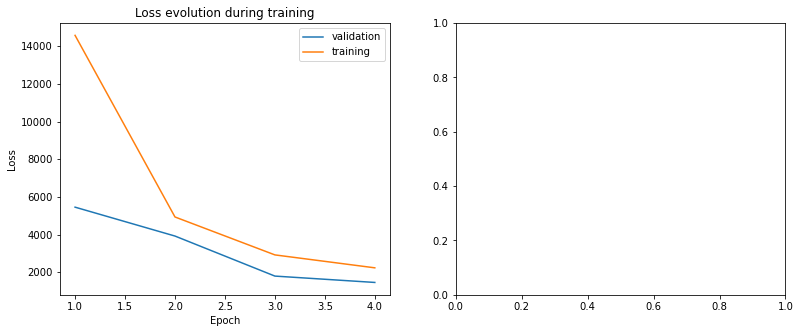

In [18]:
CNN1d = CNN1d_Model(dropout_p=0.5)
curves = train_model(
    CNN1d,
    train_ds,
    val_ds,
    epochs,
    criterion,
    batch_size,
    lr,
    use_gpu=False,
    data_augmentation=False,
)
show_curves(curves)